In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, BooleanType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 05:06:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 05:06:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## set up config

Note data availability
* Clickstream date range (Jan 2023 - Dec 2024)
* Attributes date range (Jan 2023 - Jan 2025)
* Financials date range (Jan 2023 - Jan 2025)
* Loans date range (Jan 2023 - Nov 2025)

Since the clickstream data is only up till Dec 2024, to ensure that the feature store has a full data set, we will process data only up till Dec 2024

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Table

### Loan Mgmt System (LMS) Data

In [5]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

In [6]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_loan_table(date_str, bronze_lms_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv
2023-04-01row count: 2047
saved to: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv
2023-05-01row count: 2568
saved to: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv
2023-06-01row count: 3085
saved to: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv
2023-07-01row count: 3556
saved to: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv
2023-08-01row count: 4037
saved to: datamart/bronze/lms/bronze_loan_daily_2023_08_01.csv
2023-09-01row count: 4491
saved to: datamart/bronze/lms/bronze_loan_daily_2023_09_01.csv
2023-10-01row count: 4978
saved to: datamart/bronze/lms/bronze_loan_daily_2023_10_01.csv
2023-11-01row count: 5469
saved to: datamart/bronze/lms/bronze_loan_daily_2023_11_01.csv
2023-12-01row count: 5

In [7]:
# inspect output
utils.data_processing_bronze_table.process_bronze_loan_table(date_str, bronze_lms_directory, spark).toPandas()

2024-12-01row count: 5531
saved to: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000,1000.0,1000.0,0.0,1000.0,2024-12-01
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000,1000.0,0.0,6000.0,8000.0,2024-12-01
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000,1000.0,0.0,9000.0,9000.0,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000,1000.0,1000.0,0.0,2000.0,2024-12-01
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000,1000.0,1000.0,0.0,4000.0,2024-12-01
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01


### Clickstream Data

In [8]:
# create bronze datalake
bronze_clks_directory = "datamart/bronze/clks/"

if not os.path.exists(bronze_clks_directory):
    os.makedirs(bronze_clks_directory)

In [9]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_clickstream_table(date_str, bronze_clks_directory, spark)

2023-01-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_09_01.csv
2023-10-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_10_01.csv
2023-11-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2023_11_01.csv
2023-12-01

In [10]:
# inspect output
utils.data_processing_bronze_table.process_bronze_clickstream_table(date_str, bronze_clks_directory, spark).toPandas()

2024-12-01row count: 8974
saved to: datamart/bronze/clks/bronze_clks_mthly_2024_12_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,414,22,72,57,142,192,11,139,24,63,...,179,91,20,189,-35,-19,15,66,CUS_0xdf6,2024-12-01
8970,116,-124,-108,212,-21,227,146,112,186,-65,...,38,226,319,98,9,152,17,14,CUS_0xe23,2024-12-01
8971,237,-3,-49,375,144,41,-170,324,19,266,...,7,102,64,191,124,220,231,75,CUS_0xe4e,2024-12-01
8972,5,67,211,83,207,-41,325,14,-18,41,...,109,266,28,157,131,116,101,131,CUS_0xedd,2024-12-01


### Attributes Data

In [11]:
# create bronze datalake
bronze_attr_directory = "datamart/bronze/attr/"

if not os.path.exists(bronze_attr_directory):
    os.makedirs(bronze_attr_directory)

In [12]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_attributes_table(date_str, bronze_attr_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_09_01.csv
2023-10-01row count: 487
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_10_01.csv
2023-11-01row count: 491
saved to: datamart/bronze/attr/bronze_attr_mthly_2023_11_01.csv
2023-12-01row count: 

In [13]:
# inspect output
utils.data_processing_bronze_table.process_bronze_attributes_table(date_str, bronze_attr_directory, spark).toPandas()

2024-12-01row count: 515
saved to: datamart/bronze/attr/bronze_attr_mthly_2024_12_01.csv


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x103e,Tim Kellyf,40,155-72-8070,Scientist,2024-12-01
1,CUS_0x1195,Alexk,31,822-48-3629,Manager,2024-12-01
2,CUS_0x1197,Nayako,28,799-23-8283,_______,2024-12-01
3,CUS_0x11e2,Valetkevitchr,34,809-04-1419,Musician,2024-12-01
4,CUS_0x11ec,William Schombergh,34,417-74-2163,Journalist,2024-12-01
...,...,...,...,...,...,...
510,CUS_0xe6c,Doris Frankelh,26,172-24-1577,Entrepreneur,2024-12-01
511,CUS_0xe99,Moone,48,164-90-3178,Mechanic,2024-12-01
512,CUS_0xf55,Tarmo Virkip,39,025-54-8593,Entrepreneur,2024-12-01
513,CUS_0xfd1,Frewy,32,389-55-6408,Architect,2024-12-01


### Financials Data

In [14]:
# create bronze datalake
bronze_fin_directory = "datamart/bronze/fin/"

if not os.path.exists(bronze_fin_directory):
    os.makedirs(bronze_fin_directory)

In [15]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_financials_table(date_str, bronze_fin_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_09_01.csv
2023-10-01row count: 487
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_10_01.csv
2023-11-01row count: 491
saved to: datamart/bronze/fin/bronze_fin_mthly_2023_11_01.csv
2023-12-01row count: 489
saved to: datamart

In [16]:
# inspect output
utils.data_processing_bronze_table.process_bronze_financials_table(date_str, bronze_fin_directory, spark).toPandas()

2024-12-01row count: 515
saved to: datamart/bronze/fin/bronze_fin_mthly_2024_12_01.csv


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x103e,98690.8,8262.233333,4,6,9,1_,Student Loan,6,17,...,Good,706.96,26.860663,26 Years and 11 Months,No,55.004408,913.4813186573292,Low_spent_Small_value_payments,147.7376071067124,2024-12-01
1,CUS_0x1195,30429.91,2808.825833,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,Standard,362.48,33.349050,28 Years and 11 Months,No,29.914076,82.87878577514347,Low_spent_Large_value_payments,438.08972109416084,2024-12-01
2,CUS_0x1197,92300.01,7437.667500,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,_,755.17_,26.989787,18 Years and 11 Months,Yes,49236.000000,220.8621525417414,Low_spent_Large_value_payments,581.1567885447394,2024-12-01
3,CUS_0x11e2,44986.55,3689.879167,6,5,11,1,Credit-Builder Loan,0,4,...,Good,753.21,25.586286,20 Years and 0 Months,No,23.267135,43.20363344633164,High_spent_Large_value_payments,542.5171477430948,2024-12-01
4,CUS_0x11ec,14867.69,1005.974167,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,Standard,2344.06,24.344388,17 Years and 2 Months,Yes,55.459604,100.14574834721886,Low_spent_Medium_value_payments,224.99206407779144,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0xe6c,125597.52,9367.500187,1,3,12,4,"Debt Consolidation Loan, Not Specified, Studen...",2,9,...,Good,1294.94,30.324257,30 Years and 5 Months,NM,1278.186251,964.5381161830327,Low_spent_Medium_value_payments,763.3982127892344,2024-12-01
511,CUS_0xe99,45461.54,3917.461667,6,3,5,2,"Credit-Builder Loan, and Payday Loan",20,9,...,Standard,647.24,27.264685,16 Years and 9 Months,No,69.318349,42.941001590068666,High_spent_Large_value_payments,519.4868162135749,2024-12-01
512,CUS_0xf55,78443.48_,6358.956667,7,5,23,4,"Personal Loan, Home Equity Loan, Mortgage Loan...",39,19,...,Bad,1527.77,24.704429,15 Years and 10 Months,NM,177.387563,528.7469053018515,Low_spent_Medium_value_payments,209.76119880079318,2024-12-01
513,CUS_0xfd1,78666.56999999999,6485.547500,3,4,17,4,"Not Specified, Personal Loan, Home Equity Loan...",29,10,...,Standard,1498.7,37.831762,22 Years and 5 Months,No,247.851145,252.3461368272953,High_spent_Small_value_payments,408.35746850506007,2024-12-01


## Build Silver Table

### Loan Mgmt System Data (LMS)

In [17]:
# create silver datalake
silver_lms_directory = "datamart/silver/lms/"

if not os.path.exists(silver_lms_directory):
    os.makedirs(silver_lms_directory)

In [18]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_loan_table(date_str, bronze_lms_directory, silver_lms_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530
saved to: datamart/silver/lms/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/lms/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/lms/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv row count: 2047
saved to: datamart/silver/lms/silver_loan_daily_2023_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv row count: 2568
saved to: datamart/silver/lms/silver_loan_daily_2023_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv row count: 3085
saved to: datamart/silver/lms/silver_loan_daily_2023_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv row count: 3556
saved to: datamart/silver

saved to: datamart/silver/lms/silver_loan_daily_2024_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_04_01.csv row count: 5417
saved to: datamart/silver/lms/silver_loan_daily_2024_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_05_01.csv row count: 5391
saved to: datamart/silver/lms/silver_loan_daily_2024_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_06_01.csv row count: 5418
saved to: datamart/silver/lms/silver_loan_daily_2024_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_07_01.csv row count: 5442
saved to: datamart/silver/lms/silver_loan_daily_2024_07_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_08_01.csv row count: 5531
saved to: datamart/silver/lms/silver_loan_daily_2024_08_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_09_01.csv row count: 5537
saved to: datamart/silver/lms/silver_loan_daily_2024_09_01.parquet
loaded from: datamart/bronze/lms/bronze

In [19]:
utils.data_processing_silver_table.process_silver_loan_table(date_str, bronze_lms_directory, silver_lms_directory, spark).toPandas()

loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531
saved to: datamart/silver/lms/silver_loan_daily_2024_12_01.parquet


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000.0,1000.0,1000.0,0.0,1000.0,2024-12-01,9,0,None,0
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000.0,1000.0,0.0,6000.0,8000.0,2024-12-01,8,6,2024-06-01,183
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000.0,1000.0,0.0,9000.0,9000.0,2024-12-01,10,9,2024-03-01,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000.0,1000.0,1000.0,0.0,2000.0,2024-12-01,8,0,None,0
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000.0,1000.0,1000.0,0.0,4000.0,2024-12-01,6,0,None,0
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0


### Clickstream Data

In [20]:
# create silver datalake
silver_clks_directory = "datamart/silver/clks/"

if not os.path.exists(silver_clks_directory):
    os.makedirs(silver_clks_directory)

In [21]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_clickstream_table(date_str, bronze_clks_directory, silver_clks_directory, spark)


loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_01_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_01_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_02_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_02_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_03_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_03_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_04_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_04_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_05_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_05_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_06_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2023_06_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2023_07_01.csv row count: 8974
saved to: d

saved to: datamart/silver/clks/silver_clks_mthly_2023_12_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_01_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_01_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_02_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_02_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_03_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_03_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_04_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_04_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_05_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_05_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_06_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_06_01.parquet
loaded from: datamart/bron

saved to: datamart/silver/clks/silver_clks_mthly_2024_08_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_09_01.csv row count: 8974


saved to: datamart/silver/clks/silver_clks_mthly_2024_09_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_10_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_10_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_11_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_11_01.parquet
loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_12_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_12_01.parquet


In [22]:
utils.data_processing_silver_table.process_silver_clickstream_table(date_str, bronze_clks_directory, silver_clks_directory, spark).toPandas()

loaded from: datamart/bronze/clks/bronze_clks_mthly_2024_12_01.csv row count: 8974
saved to: datamart/silver/clks/silver_clks_mthly_2024_12_01.parquet


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,0,101,82,111,24,...,65,249,200,185,0,0,0,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,0,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,0,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,0,210,0,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,0,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,414,22,72,57,142,192,11,139,24,63,...,179,91,20,189,0,0,15,66,CUS_0xdf6,2024-12-01
8970,116,0,0,212,0,227,146,112,186,0,...,38,226,319,98,9,152,17,14,CUS_0xe23,2024-12-01
8971,237,0,0,375,144,41,0,324,19,266,...,7,102,64,191,124,220,231,75,CUS_0xe4e,2024-12-01
8972,5,67,211,83,207,0,325,14,0,41,...,109,266,28,157,131,116,101,131,CUS_0xedd,2024-12-01


### Attributes Data

In [23]:
# create silver datalake
silver_attr_directory = "datamart/silver/attr/"

if not os.path.exists(silver_attr_directory):
    os.makedirs(silver_attr_directory)

In [24]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_attributes_table(date_str, bronze_attr_directory, silver_attr_directory, spark)


loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_01_01.csv row count: 530


saved to: datamart/silver/attr/silver_attr_mthly_2023_01_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_02_01.csv row count: 501
saved to: datamart/silver/attr/silver_attr_mthly_2023_02_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_03_01.csv row count: 506
saved to: datamart/silver/attr/silver_attr_mthly_2023_03_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_04_01.csv row count: 510
saved to: datamart/silver/attr/silver_attr_mthly_2023_04_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_05_01.csv row count: 521
saved to: datamart/silver/attr/silver_attr_mthly_2023_05_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_06_01.csv row count: 517
saved to: datamart/silver/attr/silver_attr_mthly_2023_06_01.parquet
loaded from: datamart/bronze/attr/bronze_attr_mthly_2023_07_01.csv row count: 471
saved to: datamart/silver/attr/silver_attr_mthly_2023_07_01.parquet
loaded from: datamart/bronze/att

In [25]:
utils.data_processing_silver_table.process_silver_attributes_table(date_str, bronze_attr_directory, silver_attr_directory, spark).toPandas()

loaded from: datamart/bronze/attr/bronze_attr_mthly_2024_12_01.csv row count: 515
saved to: datamart/silver/attr/silver_attr_mthly_2024_12_01.parquet


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x103e,Tim Kellyf,40.0,155-72-8070,Scientist,2024-12-01
1,CUS_0x1195,Alexk,31.0,822-48-3629,Manager,2024-12-01
2,CUS_0x1197,Nayako,28.0,799-23-8283,None,2024-12-01
3,CUS_0x11e2,Valetkevitchr,34.0,809-04-1419,Musician,2024-12-01
4,CUS_0x11ec,William Schombergh,34.0,417-74-2163,Journalist,2024-12-01
...,...,...,...,...,...,...
510,CUS_0xe6c,Doris Frankelh,26.0,172-24-1577,Entrepreneur,2024-12-01
511,CUS_0xe99,Moone,48.0,164-90-3178,Mechanic,2024-12-01
512,CUS_0xf55,Tarmo Virkip,39.0,025-54-8593,Entrepreneur,2024-12-01
513,CUS_0xfd1,Frewy,32.0,389-55-6408,Architect,2024-12-01


### Financials Data

In [26]:
# create silver datalake
silver_fin_directory = "datamart/silver/fin/"

if not os.path.exists(silver_fin_directory):
    os.makedirs(silver_fin_directory)

In [27]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_financials_table(date_str, bronze_fin_directory, silver_fin_directory, spark)

loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_01_01.csv row count: 530
saved to: datamart/silver/fin/silver_fin_mthly_2023_01_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_02_01.csv row count: 501
saved to: datamart/silver/fin/silver_fin_mthly_2023_02_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_03_01.csv row count: 506
saved to: datamart/silver/fin/silver_fin_mthly_2023_03_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_04_01.csv row count: 510
saved to: datamart/silver/fin/silver_fin_mthly_2023_04_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_05_01.csv row count: 521
saved to: datamart/silver/fin/silver_fin_mthly_2023_05_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_06_01.csv row count: 517
saved to: datamart/silver/fin/silver_fin_mthly_2023_06_01.parquet
loaded from: datamart/bronze/fin/bronze_fin_mthly_2023_07_01.csv row count: 471
saved to: datamart/silver/fin/silver_fin_mth

In [28]:
utils.data_processing_silver_table.process_silver_financials_table(date_str, bronze_fin_directory, silver_fin_directory, spark).toPandas()

loaded from: datamart/bronze/fin/bronze_fin_mthly_2024_12_01.csv row count: 515


saved to: datamart/silver/fin/silver_fin_mthly_2024_12_01.parquet


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,Num_Fin_Pdts,Loans_per_Credit_Item,Debt_to_Salary,EMI_to_Salary,Repayment_Ability,Loan_Extent
0,CUS_0x103e,98690.80,8262.233,4,6,9,1,Student Loan,6,17,...,913.481,0.0,147.738,2024-12-01,11,0.090909,0.085555,0.006656,8207.229,6
1,CUS_0x1195,30429.91,2808.826,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,82.879,2.0,438.090,2024-12-01,12,0.181818,0.129004,0.010646,2778.912,44
2,CUS_0x1197,92300.01,7437.668,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,220.862,2.0,581.157,2024-12-01,9,0.428571,0.101520,6.618927,-41798.332,81
3,CUS_0x11e2,44986.55,3689.879,6,5,11,1,Credit-Builder Loan,0,4,...,43.204,5.0,542.517,2024-12-01,12,0.083333,0.204073,0.006304,3666.612,0
4,CUS_0x11ec,14867.69,1005.974,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,100.146,1.0,224.992,2024-12-01,24,0.315789,2.327826,0.055076,950.514,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0xe6c,125597.52,9367.500,1,3,12,4,"Debt Consolidation Loan, Not Specified, Studen...",2,9,...,964.538,1.0,763.398,2024-12-01,8,0.800000,0.138223,0.136434,8089.314,8
511,CUS_0xe99,45461.54,3917.462,6,3,5,2,"Credit-Builder Loan, and Payday Loan",20,9,...,42.941,5.0,519.487,2024-12-01,11,0.200000,0.165177,0.017690,3848.144,40
512,CUS_0xf55,78443.48,6358.957,7,5,23,4,"Personal Loan, Home Equity Loan, Mortgage Loan...",39,19,...,528.747,1.0,209.761,2024-12-01,16,0.307692,0.240217,0.027891,6181.569,156
513,CUS_0xfd1,78666.57,6485.548,3,4,17,4,"Not Specified, Personal Loan, Home Equity Loan...",29,10,...,252.346,3.0,408.357,2024-12-01,11,0.500000,0.231047,0.038210,6237.697,116


## Build Gold Table (Features)

We will build 2 gold tables
1. engagement_tab: Stores app level data related to the customer. For simplicity, we assume feature fe_1 is the most important feature that the business wants to look at. Given that from the exploratory data analysis, the behaviour of fe_1 to fe_20 is the same.
2. cust_fin_risk_tab: Contains metrics that describe a customer's financial / credit risk profile 

### engagement_tab

In [29]:
# create gold datalake
gold_clks_directory = "datamart/gold/feature_store/eng/"

if not os.path.exists(gold_clks_directory):
    os.makedirs(gold_clks_directory)

In [30]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_fts_gold_engag_table(date_str, silver_clks_directory, gold_clks_directory, spark)

No data for 1 months ago
No data for 2 months ago
No data for 3 months ago
No data for 4 months ago
No data for 5 months ago
No data for 6 months ago
No data loaded for any of the previous 6 months.
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_01_01.parquet, row count: 8974
No data for 2 months ago
No data for 3 months ago
No data for 4 months ago
No data for 5 months ago
No data for 6 months ago
Saved to: datamart/gold/feature_store/eng/gold_ft_store_engagement_2023_02_01.parquet
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_02_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_01_01.parquet, row count: 8974
No data for 3 months ago
No data for 4 months ago
No data for 5 months ago
No data for 6 months ago
Saved to: datamart/gold/feature_store/eng/gold_ft_store_engagement_2023_03_01.parquet
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_03_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_

Saved to: datamart/gold/feature_store/eng/gold_ft_store_engagement_2023_08_01.parquet
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_08_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_07_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_06_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_05_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_04_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_03_01.parquet, row count: 8974
Saved to: datamart/gold/feature_store/eng/gold_ft_store_engagement_2023_09_01.parquet
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_09_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_08_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2023_07_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/si

In [32]:
utils.data_processing_gold_table.process_fts_gold_engag_table(date_str, silver_clks_directory, gold_clks_directory, spark).toPandas()

Loaded from: datamart/silver/clks/silver_clks_mthly_2024_11_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2024_10_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2024_09_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2024_08_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2024_07_01.parquet, row count: 8974
Loaded from: datamart/silver/clks/silver_clks_mthly_2024_06_01.parquet, row count: 8974
Saved to: datamart/gold/feature_store/eng/gold_ft_store_engagement_2024_12_01.parquet


,Customer_ID,snapshot_date,click_1m,click_2m,click_3m,click_4m,click_5m,click_6m
0,CUS_0xc65a,2024-12-01,133,93,18,0,90,140
1,CUS_0x5e1f,2024-12-01,0,1,208,347,109,0
2,CUS_0x78d3,2024-12-01,159,0,119,9,62,132
3,CUS_0x1844,2024-12-01,90,152,60,52,227,64
4,CUS_0x7f07,2024-12-01,26,170,37,99,225,226
...,...,...,...,...,...,...,...,...
8969,CUS_0x8a04,2024-12-01,108,47,252,73,128,208
8970,CUS_0x7f3f,2024-12-01,0,0,96,157,190,11
8971,CUS_0x915,2024-12-01,0,121,93,11,129,0
8972,CUS_0x4b67,2024-12-01,226,69,48,0,151,152


### cust_fin_risk_tab

In [33]:
# create gold datalake
gold_fin_directory = "datamart/gold/feature_store/cust_fin_risk/"

if not os.path.exists(gold_fin_directory):
    os.makedirs(gold_fin_directory)

In [34]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_fts_gold_cust_risk_table(date_str, silver_fin_directory, gold_fin_directory, spark)

loaded from: datamart/silver/fin/silver_fin_mthly_2023_01_01.parquet row count: 530
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2023_01_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2023_02_01.parquet row count: 501
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2023_02_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2023_03_01.parquet row count: 506
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2023_03_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2023_04_01.parquet row count: 510
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2023_04_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2023_05_01.parquet row count: 521
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2023_05_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2023_06_01.parquet row count: 517
s

loaded from: datamart/silver/fin/silver_fin_mthly_2024_06_01.parquet row count: 498


saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_06_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2024_07_01.parquet row count: 505
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_07_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2024_08_01.parquet row count: 543
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_08_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2024_09_01.parquet row count: 493
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_09_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2024_10_01.parquet row count: 456
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_10_01.parquet
loaded from: datamart/silver/fin/silver_fin_mthly_2024_11_01.parquet row count: 488
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_

In [27]:
utils.data_processing_gold_table.process_fts_gold_cust_risk_table(date_str, silver_fin_directory, gold_fin_directory, spark).toPandas()

loaded from: datamart/silver/fin/silver_fin_mthly_2024_12_01.parquet row count: 515
saved to: datamart/gold/feature_store/cust_fin_risk/gold_ft_store_cust_fin_risk_2024_12_01.parquet


,Customer_ID,snapshot_date,Credit_History_Age,Num_Fin_Pdts,EMI_to_Salary,Debt_to_Salary,Repayment_Ability,Loans_per_Credit_Item,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit
0,CUS_0x103e,2024-12-01,323,11,0.006656,0.085555,8207.229,0.090909,6,706.96,9,6,10.76
1,CUS_0x1195,2024-12-01,347,12,0.010646,0.129004,2778.912,0.181818,44,362.48,16,22,1.67
2,CUS_0x1197,2024-12-01,227,9,6.618927,0.101520,-41798.332,0.428571,81,755.17,11,27,18.96
3,CUS_0x11e2,2024-12-01,240,12,0.006304,0.204073,3666.612,0.083333,0,753.21,11,0,10.26
4,CUS_0x11ec,2024-12-01,206,24,0.055076,2.327826,950.514,0.315789,234,2344.06,18,39,18.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0xe6c,2024-12-01,365,8,0.136434,0.138223,8089.314,0.800000,8,1294.94,12,2,9.89
511,CUS_0xe99,2024-12-01,201,11,0.017690,0.165177,3848.144,0.200000,40,647.24,5,20,11.38
512,CUS_0xf55,2024-12-01,190,16,0.027891,0.240217,6181.569,0.307692,156,1527.77,23,39,6.37
513,CUS_0xfd1,2024-12-01,269,11,0.038210,0.231047,6237.697,0.500000,116,1498.70,17,29,5.37


## Inspect Feature Store

In [35]:
folder_path = gold_clks_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 206402
+-----------+-------------+--------+--------+--------+--------+--------+--------+
|Customer_ID|snapshot_date|click_1m|click_2m|click_3m|click_4m|click_5m|click_6m|
+-----------+-------------+--------+--------+--------+--------+--------+--------+
| CUS_0xc65a|   2024-03-01|     239|     236|      44|     309|       0|      35|
| CUS_0x5e1f|   2024-03-01|     103|      26|     182|     133|      27|      43|
| CUS_0x78d3|   2024-03-01|      69|     124|     140|       0|       0|     149|
| CUS_0x1844|   2024-03-01|     142|     232|      25|     145|       0|      97|
| CUS_0x7f07|   2024-03-01|      53|       0|     256|     158|     160|     141|
| CUS_0xbd2c|   2024-03-01|      93|      70|     318|      49|     329|     155|
| CUS_0x9d41|   2024-03-01|      69|       0|      47|      59|      39|      84|
| CUS_0x834f|   2024-03-01|     240|      49|      16|      24|     171|      52|
| CUS_0x4b6b|   2024-03-01|       8|     157|     274|      41|     155|     124

In [36]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- click_1m: integer (nullable = true)
 |-- click_2m: integer (nullable = true)
 |-- click_3m: integer (nullable = true)
 |-- click_4m: integer (nullable = true)
 |-- click_5m: integer (nullable = true)
 |-- click_6m: integer (nullable = true)



In [37]:
folder_path = gold_fin_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 11974
+-----------+-------------+------------------+------------+--------------------+--------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
|Customer_ID|snapshot_date|Credit_History_Age|Num_Fin_Pdts|       EMI_to_Salary|      Debt_to_Salary| Repayment_Ability|Loans_per_Credit_Item|Loan_Extent|Outstanding_Debt|Interest_Rate|Delay_from_due_date|Changed_Credit_Limit|
+-----------+-------------+------------------+------------+--------------------+--------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
| CUS_0x10ac|   2024-08-01|               195|          14| 0.04008904831579113|  0.6713314768490112|          1219.258|  0.36363636363636365|        104|          853.41|           15|                 26|               18.45|
| CUS_0x10c5|   2024-08-01|               362|          10|0.00690614346653

In [38]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Credit_History_Age: integer (nullable = true)
 |-- Num_Fin_Pdts: integer (nullable = true)
 |-- EMI_to_Salary: double (nullable = true)
 |-- Debt_to_Salary: double (nullable = true)
 |-- Repayment_Ability: double (nullable = true)
 |-- Loans_per_Credit_Item: double (nullable = true)
 |-- Loan_Extent: integer (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)



## Build Gold Table (Label)

### EDA on credit labels

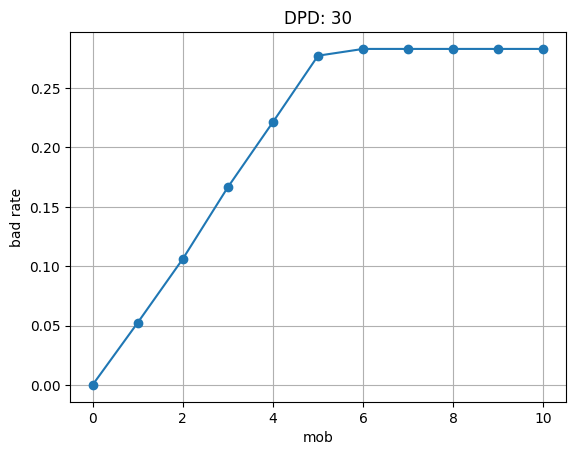

In [43]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_lms_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [44]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

### Loan Data

In [45]:
# create gold datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [46]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_lms_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)

loaded from: datamart/silver/lms/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2023_02_01.parquet row count: 1031
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_20

saved to: datamart/gold/label_store/gold_label_store_2024_03_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_04_01.parquet row count: 5417
saved to: datamart/gold/label_store/gold_label_store_2024_04_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_05_01.parquet row count: 5391
saved to: datamart/gold/label_store/gold_label_store_2024_05_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_06_01.parquet row count: 5418
saved to: datamart/gold/label_store/gold_label_store_2024_06_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_07_01.parquet row count: 5442
saved to: datamart/gold/label_store/gold_label_store_2024_07_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_08_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_08_01.parquet
loaded from: datamart/silver/lms/silver_loan_daily_2024_09_01.parquet row count: 5537
saved to: datamart/gold/label_store/gold_label_store

In [47]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_lms_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes

loaded from: datamart/silver/lms/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## Inspect Label Store

In [48]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [49]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



## Stop Spark Session

In [50]:
spark.stop()